# Lab-based Group Assignment 3: 
## Signature Authentication to Prevent Fraud Transactions in Business



![Imgur](https://i.imgur.com/r1U9dHD.png) 

## **Business Problem**
In a legal context, a signature is your name written in a distinct, personalized form as a way of identifying yourself to authorize a document. Using signiture for identity validation is still a global-wide practice for legal authentication.

In order to **prevent fraud transactions, a bank’s established practice** is to compare the signature on a request to the signature maintained in the bank’s file system and to confirm that the request is issued by the correct issuer.

Without modern signiture authentication technology, banks around the world had suffered huge losses against fraud transaction in which  signitures are maliciously forged.
\
\
(Optional) Read More about a real-life signiture-related legal case:  
<a href="http://www.joneslemongraham.com/blog/banks-loss-a-covered-forgery-under-insuring-agreement-d-of-financial-institution-bond-and-not-excluded-by-loan-loss-exclusion/#.X2bDBy9h1PM">Bank of Ann Arbor v. Everest National Insurance Company, Case No. 12-11251 (E.D. Mi. Feb. 25, 2013)</a>
\
\
Luckily, we have advanced computer vision technology, which can conveniently and accurately identify forged signitures.


![Imgur](https://i.imgur.com/f9Ozq9M.png)

<img src="https://storage.googleapis.com/kaggle-datasets-images/107946/257611/57ea0c6f63a05a981b18eb7ad5547464/dataset-cover.png?t=2019-01-20-18-39-59">

### **Task**
Build a deep learning model to classify forged signatures from genuine signitures to prevent fraud transactions in businesses. 

---

In [ ]:
# First things first: Please select a GPU backend.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
Click the folder button on the left, and Colab will display a file window. (Probably you might have to wait for at most 10 seconds, before the `drive` folder shows up.) Find the zip file `signature-verification-dataset.zip` under the drive folder.  

Right click the file and select "copy path". Now the file path is on your clip board. Paste the path inside the double quote in the next code chunk.

## Q1: Please unzip, read and seperate the dataset for the model?

In [ ]:
# Unzip signature-verification-dataset.zip to "/content" directory. 
!unzip -q "/content/drive/MyDrive/565e colab files 9 13/lab/Lab-based Group Assignment 3/signature-verification-dataset.zip" -d /content/

In [ ]:
import pandas as pd
# Load data
X="file_name"
Y="forged"
train_df=pd.read_csv("/content/sign_data/train_data.csv",header=None,usecols=[1,2],names=[X,Y],dtype=str)
test_df=pd.read_csv("/content/sign_data/test_data.csv",header=None,usecols=[1,2],names=[X,Y],dtype=str)

# Train Test Split
from sklearn.model_selection import train_test_split
validation_df,test_df=train_test_split(test_df,test_size=0.5)
print(train_df.shape,validation_df.shape,test_df.shape)

(23206, 2) (2874, 2) (2874, 2)


In [ ]:
display(train_df)
# See how many genuine/forged signitures in train data?
train_df.forged.value_counts()

,file_name,forged
0,068_forg/03_0113068.PNG,1
1,068_forg/01_0124068.PNG,1
2,068_forg/02_0124068.PNG,1
3,068_forg/01_0113068.PNG,1
4,068_forg/04_0124068.PNG,1
...,...,...
23201,031/03_031.png,0
23202,031/12_031.png,0
23203,031/11_031.png,0
23204,031/06_031.png,0


0    12602
1    10604
Name: forged, dtype: int64

In [ ]:
# Define the data path, we will use it later.
path="/content/sign_data/"

In [ ]:
# The mode of image
from PIL import Image
Image.open("/content/sign_data/train/001/001_01.PNG").mode

'RGB'

## Q2: Please generate new dataset by using ImageDataGenerator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Instantiate ImageDataGenerator class
train_datagen = ImageDataGenerator(rescale=1./255)

# Configure train data generator
train_gen=train_datagen.flow_from_dataframe( 
    train_df,                                   # Pandas dataframe containing the filepaths relative to directory (or absolute paths if directory is None) of the images in a string column.
    directory="/content/sign_data/train",       # string, path to the directory to read images from. If None, data in x_col column should be absolute paths.
    x_col=X,                          # string, column in dataframe that contains the filenames (or absolute paths if directory is None).
    y_col=Y,                             # string or list, column/s in dataframe that has the target data.
    target_size=(128, 256),                     # tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized. 
    color_mode="rgb",                           # one of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1 or 3 color channels.
    class_mode="binary",                        # one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". If y_col is a binary class (0 or 1), you should use "binary". If y_col is numeric value array, you should use "raw".
    batch_size=32,   # size of the batches of data (default: 32). This batchsize is different from the one in model.fit(). It is just another batchsize served for converting original images to executable format for neural network.
    shuffle=True)                               # whether to shuffle the data (default: True). This is for eliminating bias in generating input data

# Configure validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)
val_gen=val_datagen.flow_from_dataframe(
    validation_df,
    directory="/content/sign_data/train",
    x_col=X,
    y_col=Y,
    target_size=(128, 256),
    color_mode="rgb",
    class_mode="binary",
    ) #In the generation of validation and test dataset, its not necessary to define batchsize and shuffle. Because only training dataset is taken for training.

# Configure test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen=test_datagen.flow_from_dataframe(
    test_df,
    directory="/content/sign_data/test",
    x_col=X,
    y_col=Y,
    target_size=(128, 256),
    color_mode="rgb",
    class_mode="binary",
    )

Found 23206 validated image filenames belonging to 2 classes.
Found 2874 validated image filenames belonging to 2 classes.
Found 2874 validated image filenames belonging to 2 classes.


## Q3: Please use dense neural networks for predict the forged signatures. 

In [ ]:
# Build sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense

model=Sequential()
model.add(Flatten())   # Flatten the channels into one single long array
model.add(Dense(2048 ,input_shape = (128*256*3,) ,activation = 'relu'))     
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss="binary_crossentropy",                   #computes the cross-entropy loss between true labels and predicted labels
              optimizer="adam",
              metrics=['acc'])

history=model.fit(train_gen,                                # Train data generator
      steps_per_epoch=train_gen.n//train_gen.batch_size,    #train_gen.n//train_gen.batch_size. In lab 2, we set "batchsize" in model.fit() to determine the step length for steps in one epoch. 
                  #Steps_per_epoch is the number of steps in one epoch. It can also determine the step length (batchszie) in each epoch. So, we can set steps_per_epoch instead to replace "batchsize".
                  #Either batchsize or steps_per_epoch is fine. Just make sure you set one of them.
      epochs=10,                                             
      validation_data=val_gen,                              # Validation data generator                      
      validation_steps=val_gen.n//val_gen.batch_size)       # val_gen.n//val_gen.batch_size, Need to sepcify this parameter.        "//" means get the integer part from division result.

Epoch 1/10
725/725 [==============================] - 86s 118ms/step - loss: 5.3775 - acc: 0.5229 - val_loss: 0.6749 - val_acc: 0.5994
Epoch 2/10
725/725 [==============================] - 85s 117ms/step - loss: 0.6969 - acc: 0.5438 - val_loss: 0.6940 - val_acc: 0.4849
Epoch 3/10
725/725 [==============================] - 85s 117ms/step - loss: 0.6901 - acc: 0.5429 - val_loss: 0.6983 - val_acc: 0.4846
Epoch 4/10
725/725 [==============================] - 85s 118ms/step - loss: 0.6895 - acc: 0.5431 - val_loss: 0.6987 - val_acc: 0.4846
Epoch 5/10
725/725 [==============================] - 85s 117ms/step - loss: 0.6895 - acc: 0.5432 - val_loss: 0.6991 - val_acc: 0.4863
Epoch 6/10
725/725 [==============================] - 85s 118ms/step - loss: 0.6895 - acc: 0.5429 - val_loss: 0.6990 - val_acc: 0.4856
Epoch 7/10
725/725 [==============================] - 85s 117ms/step - loss: 0.6895 - acc: 0.5432 - val_loss: 0.6996 - val_acc: 0.4828
Epoch 8/10
725/725 [==============================] - 8

Evaluate the accruacy of the result. Why do we have the low accuracy of the result?

It does not work very well because we have lots of neurons in the input layer.

## Q4: Please use CNNs to predict the forged signatures with high accuracy. 

#### Larger Convolution Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback 

# Build sequential model
model=Sequential()
model.add(Conv2D(128, 3,input_shape=(128,256,3),activation="relu"))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3,activation="relu"))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.5))                                                         # Add Dropout layer, randomly drops 50% neurons from propagation.
model.add(Dense(64,activation="relu", kernel_regularizer="l2"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['acc'])

# Configure EarlyStopping object
Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)      # EarlyStopping with patience 2: if in 2 consecutive epochs, the validation loss didn't hit the record, training will stop.

# Fit the model and record the training history for plotting purpose
history=model.fit(train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size, #train_gen.n//train_gen.batch_size. In lab 2, we set "batchsize" in model.fit() to determine the step length for steps in one epoch. 
                  #Steps_per_epoch is the number of steps in one epoch. It can also determine the step length (batchszie) in each epoch. So, we can set steps_per_epoch instead to replace "batchsize".
                  #Either batchsize or steps_per_epoch is fine. Just make sure you set one of them.
      epochs=10,
      validation_data=val_gen,
      validation_steps=val_gen.n//val_gen.batch_size, #val_gen.n//val_gen.batch_size
      callbacks=[Es])                                                           # Here is how we use EarlyStopping

Epoch 1/10
725/725 [==============================] - 100s 124ms/step - loss: 0.3563 - acc: 0.9112 - val_loss: 0.1726 - val_acc: 0.9775
Epoch 2/10
725/725 [==============================] - 87s 120ms/step - loss: 0.1761 - acc: 0.9797 - val_loss: 0.1228 - val_acc: 0.9975
Epoch 3/10
725/725 [==============================] - 87s 120ms/step - loss: 0.1316 - acc: 0.9899 - val_loss: 0.1194 - val_acc: 0.9975
Epoch 4/10
725/725 [==============================] - 87s 120ms/step - loss: 0.1143 - acc: 0.9930 - val_loss: 0.1042 - val_acc: 0.9940
Epoch 5/10
725/725 [==============================] - 88s 121ms/step - loss: 0.1217 - acc: 0.9920 - val_loss: 0.1064 - val_acc: 0.9982
Epoch 6/10
725/725 [==============================] - 86s 119ms/step - loss: 0.0993 - acc: 0.9943 - val_loss: 0.0823 - val_acc: 1.0000
Epoch 7/10
725/725 [==============================] - 86s 118ms/step - loss: 0.0991 - acc: 0.9950 - val_loss: 0.0737 - val_acc: 1.0000
Epoch 8/10
725/725 [==============================] - 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 127, 128)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 125, 64)       73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 119040)            0         
                                                                 
 dropout (Dropout)           (None, 119040)            0

What can we learn from the model summary?

We have a dimension of 119040 after convolution layers, which is more than the 100 thousand dimension menstioned at the beginning. In this situation, we did not actually reduce the dimension. What we need to do next is to simplify the convolution models.

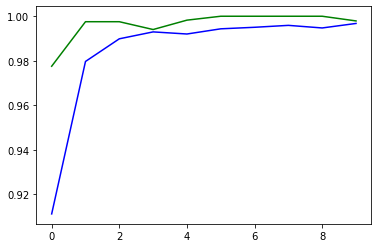

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='g')
plt.show()

In [ ]:
# Evaluate test data accuracy.
model.evaluate(test_gen)

180/180 [==============================] - 121s 673ms/step - loss: 0.6989 - acc: 0.4823


[0.6988679766654968, 0.48225468397140503]

#### Convolution Model

In [ ]:
# Final version
# Build sequential model
model=Sequential()
model.add(Conv2D(128, 3,input_shape=(128,256,3),activation="relu"))
model.add(MaxPooling2D(2))
#model.add(Conv2D(64, 3,activation="relu"))
#model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.5))                                                         # Add Dropout layer, randomly drops 50% neurons from propagation.
model.add(Dense(64,activation="relu", kernel_regularizer="l2"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['acc'])

# Configure EarlyStopping object
Es=EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)      # EarlyStopping with patience 2: if in 2 consecutive epochs, the validation loss didn't hit the record, training will stop.

# Fit the model and record the training history for plotting purpose
history=model.fit(train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size, #train_gen.n//train_gen.batch_size
      epochs=10,
      validation_data=val_gen,
      validation_steps=val_gen.n//val_gen.batch_size, #val_gen.n//val_gen.batch_size
      callbacks=[Es])                                                           # Here is how we use EarlyStopping

      

Epoch 1/10
725/725 [==============================] - 86s 118ms/step - loss: 1.1557 - acc: 0.8866 - val_loss: 0.4977 - val_acc: 0.9329
Epoch 2/10
725/725 [==============================] - 86s 119ms/step - loss: 0.4847 - acc: 0.9554 - val_loss: 0.4783 - val_acc: 0.9814
Epoch 3/10
725/725 [==============================] - 85s 117ms/step - loss: 0.3938 - acc: 0.9736 - val_loss: 0.4062 - val_acc: 0.9937
Epoch 4/10
725/725 [==============================] - 85s 118ms/step - loss: 0.3348 - acc: 0.9832 - val_loss: 0.3006 - val_acc: 0.9954
Epoch 5/10
725/725 [==============================] - 85s 117ms/step - loss: 0.2999 - acc: 0.9878 - val_loss: 0.3013 - val_acc: 0.9947
Epoch 6/10
725/725 [==============================] - 86s 118ms/step - loss: 0.2892 - acc: 0.9893 - val_loss: 0.3575 - val_acc: 0.9958


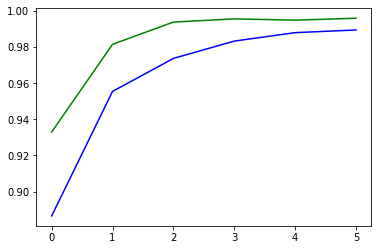

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='g')
plt.show()

This simple convolution model's performance is similar to dense model. 

#### Basic Convolution Model

In [ ]:
# Intermediate version
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback

model=Sequential()                                                      
model.add(Conv2D(128, 3,input_shape=(128, 256,3),activation="relu"))     # The first convolution layer: 16 filters with size 3x3.
#model.add(MaxPooling2D(2))
#model.add(Conv2D(64, 3,activation="relu"))
model.add(MaxPooling2D(2))                                              # Pooling: MaxPooling
model.add(Flatten())                                                    # Flatten the output of pooling layer i.e. create a long array
#model.add(Dropout(0.5))                                                    
model.add(Dense(64,activation="relu")) # No L2 regularizer here
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",                               # This is binary classification
              optimizer="adam",                                         # Adam optimizer
              metrics=['acc'])                                          # Monitoring the accuracy

# Fit the model and record the training history for plotting purpose
history=model.fit(train_gen,
      steps_per_epoch=train_gen.n//train_gen.batch_size, #train_gen.n//train_gen.batch_size
      epochs=10,
      validation_data=val_gen,
      validation_steps=val_gen.n//val_gen.batch_size) #val_gen.n//val_gen.batch_size

Epoch 1/10
725/725 [==============================] - 85s 117ms/step - loss: 0.1980 - acc: 0.9568 - val_loss: 4.6877e-04 - val_acc: 1.0000
Epoch 2/10
725/725 [==============================] - 85s 117ms/step - loss: 2.1171e-04 - acc: 1.0000 - val_loss: 1.0657e-04 - val_acc: 1.0000
Epoch 3/10
725/725 [==============================] - 84s 116ms/step - loss: 5.8029e-05 - acc: 1.0000 - val_loss: 3.9191e-05 - val_acc: 1.0000
Epoch 4/10
725/725 [==============================] - 84s 116ms/step - loss: 2.2100e-05 - acc: 1.0000 - val_loss: 1.7271e-05 - val_acc: 1.0000
Epoch 5/10
725/725 [==============================] - 85s 117ms/step - loss: 1.0673e-05 - acc: 1.0000 - val_loss: 9.1546e-06 - val_acc: 1.0000
Epoch 6/10
725/725 [==============================] - 84s 116ms/step - loss: 5.8819e-06 - acc: 1.0000 - val_loss: 5.2610e-06 - val_acc: 1.0000
Epoch 7/10
725/725 [==============================] - 84s 116ms/step - loss: 3.5017e-06 - acc: 1.0000 - val_loss: 3.4353e-06 - val_acc: 1.0000
Epo

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 254, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 127, 128)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1024128)           0         
                                                                 
 dense_5 (Dense)             (None, 64)                65544256  
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                      

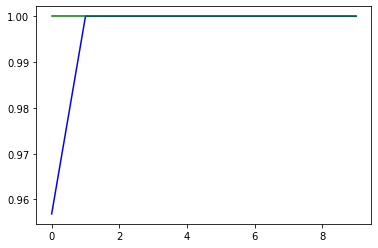

In [ ]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='g')
plt.show()

In [ ]:
model.evaluate(test_gen)

90/90 [==============================] - 10s 108ms/step - loss: 8.9584e-07 - acc: 1.0000


[8.958388093560643e-07, 1.0]

In [ ]:
model.save('/content/modelsign.h5')

## Discussion

Questions:

#### What is the reason that we have 100 percent accuracy and is this okay for the problem?


- Do you believe that is the real accuracy?


- Is this model overfitting model or undefitting model?  


- Is there any imbalance learning problem here?


- Why we are using validation dataset? If the training results and validation results are same, what we are going to do?


- Could we train this model with medium size architecture? 


Answers:

#### What is the reason that we have 100 percent accuracy and is this okay for the problem?

- Do you believe that is the real accuracy?
  - Three issues we need to consider here. 
  - Less Generalization, Data Leakage, Clear Patterns.

- Is this model overfitting model or undefitting model?  
  - Based on the current dataset, it is trained well. 
  - But, based on the business problem, it is underfitting because we need more samples for representing our business problem. 
  - There is no variance for validation set, and it is very hard to optimize the parameters. 
  - The results are good. But, when we deployed the model, it will not work because the model did not see all cases. 
  - We need to train multiple models and make the decision because we need to look at the different perspective. 

- Is there any imbalance learning problem here?
  - No, we have samples around 10000 and 8000 for classes. 

- Why we are using validation dataset? If the training results and validation results are same, what we are going to do?
  - We used it to optimize the hyper parameters, and the results are same in this model. You have a chance to make your model more simple or complex. 
  - If we have 100 percent accuracy, there is no error, no variance, high bias, then underfitting problem.
  - We need to look at two parts as model and dataset. It is not about the model. We need to look at the dataset for fixing this problem. 

- Could we train this model with medium size architecture? 
  - We can train it. But, we already have good results based on this dataset. 

  In the model, there is sample bias in the dataset because our samples does not cover the enviorenment. We need to collect more dataset and cover all cases. 
  
  We also have exclusion bias. Some features are irrelavent of the output. 





Bias and Fairness in DL

https://medium.com/dev-genius/bias-and-fairness-in-machine-learning-part-1-introducing-our-dataset-and-the-problem-24f5f15c4f23

How to fix bias in the dataset?

https://towardsdatascience.com/5-types-of-bias-how-to-eliminate-them-in-your-machine-learning-project-75959af9d3a0

If you have any questions, please contact me at salihtutun@wustl.edu.

Salih Tutun, Ph.D.